<center><h1 class="list-group-item list-group-item-success">Arrhythmia Detection</h1></center>

## Loading modules

In [29]:
import pandas as pd
import numpy as np
import wfdb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

In [2]:
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Dropout, TimeDistributed
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam # - Works

In [3]:
import matplotlib.pyplot as plt

## Download Dataset

In [4]:
import wget
import zipfile

database_filename = "mit-bih-arrhythmia-database-1.0.0.zip"
database_path = Path(database_filename)

if not database_path.exists():
    url = f'https://storage.googleapis.com/mitdb-1.0.0.physionet.org/{database_filename}'
    wget.download(url)
    with zipfile.ZipFile(database_filename, 'r') as zip_ref:
        zip_ref.extractall(".")

## Loading data

Loading list of records available, from dataset available [here](https://physionet.org/content/mitdb/1.0.0/)

In [5]:
records = np.loadtxt("mit-bih-arrhythmia-database-1.0.0/RECORDS", dtype=int)

Defining invalid beats as well as abnormal beats, according to [Physiobank](https://archive.physionet.org/physiobank/annotations.shtml)

In [6]:
invalid_beat = [
    "[", "!", "]", "x", "(", ")", "p", "t", 
    "u", "`", "'", "^", "|", "~", "+", "s", 
    "T", "*", "D", "=", '"', "@"
]

abnormal_beats = [
    "L", "R", "B", "A", "a", "J", "S", "V", 
    "r", "F", "e", "j", "n", "E", "/", "f", "Q", "?"
]

## Processing dataset

This function classify a beat according to its symbol and the list provided above.

In [7]:
def classify_beat(symbol):
    if symbol in abnormal_beats:
        return 1
    elif symbol == "N" or symbol == ".":
        return 0    

Given a signal, the beat location, and the window to be used as a sequence, this function gets the sequence. It will return an empty array in case of an invalid beat or empty sequence.

In [8]:
def get_sequence(signal, beat_loc, window_sec, fs):
    window_one_side = window_sec * fs
    beat_start = beat_loc - window_one_side
    beat_end = beat_loc + window_one_side
    if beat_end < signal.shape[0]:
        sequence = signal[beat_start:beat_end, 0]
        return sequence.reshape(1, -1, 1)
    else:
        return np.array([])

The code below will build a list of labels and sequences as well as map the sequences for each patient. The percentage calculated represents the ratio of abnormal beats in each patient data.

In [9]:
all_sequences = []
all_labels = []
window_sec = 3
subject_map = []
for subject in records:
    record = wfdb.rdrecord(f'mit-bih-arrhythmia-database-1.0.0/{subject}')
    annotation = wfdb.rdann(f'mit-bih-arrhythmia-database-1.0.0/{subject}', 'atr')
    atr_symbol = annotation.symbol
    atr_sample = annotation.sample
    fs = record.fs
    scaler = StandardScaler()
    signal = scaler.fit_transform(record.p_signal)
    subject_labels = []
    for i, i_sample in enumerate(atr_sample):
        label = classify_beat(atr_symbol[i])
        sequence = get_sequence(signal, i_sample, window_sec, fs)
        if label is not None and sequence.size > 0:
            all_sequences.append(sequence)
            subject_labels.append(label)

    normal_percentage = sum(subject_labels) / len(subject_labels)
    subject_map.append({
        "subject": subject,
        "percentage": normal_percentage,
        "num_seq": len(subject_labels),
        "start": len(all_labels),
        "end": len(all_labels)+len(subject_labels)
    })
    all_labels.extend(subject_labels)

Creating bins to be used to stratify the train and validation split. 

In [10]:
subject_map = pd.DataFrame(subject_map)

The code presented will create class in each patient is segmented.

In [11]:
bins = [0, 0.2, 0.6, 1.0]
subject_map["bin"] = pd.cut(subject_map['percentage'], bins=bins, labels=False, include_lowest=True)

Now, the dataset is split into train and validation, stratifying by the bin defined above.

In [12]:
train, validation = train_test_split(subject_map, test_size=0.25, stratify=subject_map["bin"], random_state=42)

This function build a dataset based on the map for each split.

In [13]:
def build_dataset(df, all_sequences, all_labels):
    sequences = []
    labels = []
    for i, row in df.iterrows():
        start = int(row["start"])
        end = int(row["end"])
        sequences.extend(all_sequences[start:end])
        labels.extend(all_labels[start:end])
        
    return np.vstack(sequences), np.vstack(labels)

In [14]:
X_train, y_train = build_dataset(train, all_sequences, all_labels)
X_val, y_val = build_dataset(validation, all_sequences, all_labels)

In [15]:
X_train.shape, y_train.shape

((82873, 2160, 1), (82873, 1))

## Training the model

### CNN model

In [16]:
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, Dense, Dropout

sequence_size = X_train.shape[1]
n_features = 1

cnn_model = Sequential([
    Conv1D(
        filters=8,
        kernel_size=4,
        strides=1,
        input_shape=(sequence_size, n_features),
        padding="same",
        activation="relu"
    ),
    Flatten(),
    Dropout(0.5),
    Dense(
        1,
        activation="sigmoid",
        name="output",
    )
])

optimizer = Adam(learning_rate=0.001)
# Compiling the model
cnn_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2160, 8)           40        
                                                                 
 flatten (Flatten)           (None, 17280)             0         
                                                                 
 dropout (Dropout)           (None, 17280)             0         
                                                                 
 output (Dense)              (None, 1)                 17281     
                                                                 
Total params: 17,321
Trainable params: 17,321
Non-trainable params: 0
_________________________________________________________________


In [17]:
hist_cnn = cnn_model.fit(
    X_train, 
    y_train, 
    batch_size=128,
    epochs=15,
    validation_data=(X_val, y_val)
)

Epoch 1/15
648/648 [==============================] - 23s 35ms/step - loss: 0.2498 - accuracy: 0.9113 - val_loss: 0.5767 - val_accuracy: 0.8092
Epoch 2/15
648/648 [==============================] - 21s 33ms/step - loss: 0.1944 - accuracy: 0.9354 - val_loss: 0.5971 - val_accuracy: 0.8252
Epoch 3/15
648/648 [==============================] - 22s 34ms/step - loss: 0.1829 - accuracy: 0.9411 - val_loss: 0.5960 - val_accuracy: 0.8262
Epoch 4/15
648/648 [==============================] - 23s 36ms/step - loss: 0.1755 - accuracy: 0.9429 - val_loss: 0.6157 - val_accuracy: 0.8182
Epoch 5/15
648/648 [==============================] - 22s 33ms/step - loss: 0.1686 - accuracy: 0.9467 - val_loss: 0.6109 - val_accuracy: 0.8224
Epoch 6/15
648/648 [==============================] - 25s 38ms/step - loss: 0.1626 - accuracy: 0.9477 - val_loss: 0.6031 - val_accuracy: 0.8170
Epoch 7/15
648/648 [==============================] - 23s 35ms/step - loss: 0.1572 - accuracy: 0.9496 - val_loss: 0.6159 - val_accuracy:

In [18]:
cnn_model.evaluate(X_val, y_val)

821/821 [==============================] - 2s 3ms/step - loss: 0.6615 - accuracy: 0.8158


[0.6615373492240906, 0.8157584071159363]

In [19]:
X_val[0]

array([[ 0.1429364 ],
       [ 0.11962729],
       [ 0.09631817],
       ...,
       [-0.31159139],
       [-0.30576411],
       [-0.30576411]])

In [20]:
X_val.shape

(26259, 2160, 1)

In [21]:
type(X_val)

numpy.ndarray

In [22]:
predictions = cnn_model.predict(X_val)

In [23]:
predictions

array([[9.9352801e-01],
       [9.9915230e-01],
       [9.9937409e-01],
       ...,
       [2.1374226e-04],
       [3.6063790e-04],
       [1.7064810e-04]], dtype=float32)

In [24]:
y_val

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

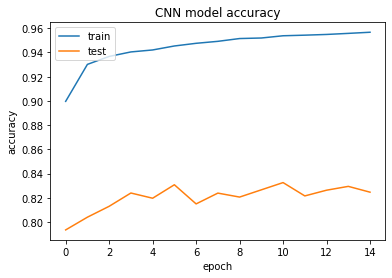

In [27]:
# summarize history for accuracy
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

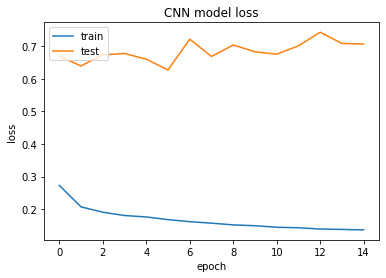

In [28]:
# summarize history for loss
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
import json
from json import JSONEncoder
import numpy

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)
    
numpyArrayOne = X_val[0]

# Serialization
numpyData = {"signal_data": numpyArrayOne}
encodedNumpyData = json.dumps(numpyData, cls=NumpyArrayEncoder)  # use dump() to write array into file
print("Printing JSON serialized NumPy array\n\n")
print(encodedNumpyData)

# Deserialization
print("Decode JSON serialized NumPy array")
decodedArrays = json.loads(encodedNumpyData)

# finalNumpyArray = numpy.asarray(decodedArrays["array"])
# print("NumPy Array")
# print(finalNumpyArray)

Printing JSON serialized NumPy array


{"signal_data": [[0.14293640426827192], [0.11962728663070521], [0.09631816899313851], [0.04969993371800509], [0.008908977852263352], [-0.0027455809665199796], [0.00308169844287167], [-0.020227419194695024], [-0.03188197801347839], [-0.055191095651045116], [-0.09598205151678682], [-0.08432749269800346], [-0.09015477210739514], [-0.1018093309261785], [-0.13094572797313683], [-0.15425484561070357], [-0.16590940442948693], [-0.16008212502009525], [-0.1484275662013119], [-0.15425484561070357], [-0.1717366838388786], [-0.16590940442948693], [-0.183391242657662], [-0.183391242657662], [-0.16590940442948693], [-0.1775639632482703], [-0.183391242657662], [-0.20670036029522865], [-0.18921852206705367], [-0.19504580147644535], [-0.1717366838388786], [-0.1717366838388786], [-0.16590940442948693], [-0.183391242657662], [-0.18921852206705367], [-0.20087308088583702], [-0.1717366838388786], [-0.16590940442948693], [-0.1717366838388786], [-0.183391242657662], [-0

In [37]:
# Save the model in H5 format
cnn_model.save('modelCnn.h5')

In [30]:
# Save the model in pickel format
pickle.dump(cnn_model, open('modelCnn.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://803eb097-3e38-4cb3-ac84-adb8200fbc47/assets


In [ ]:
# Saving the model for Future Inferences

model_json = cnn_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

### CNN with LSTM model

In [38]:
sequence_size = X_train.shape[1]
n_features = 1 
n_subsequences = 4
subsequence_size = int(sequence_size / n_subsequences)

# Reshaping to be (samples, subsequences, sequence, feature)
X_train = X_train.reshape(-1, n_subsequences, subsequence_size, n_features)
X_val = X_val.reshape(-1, n_subsequences, subsequence_size, n_features)

In [57]:
subsequence_size

540

In [55]:
X_val.shape

(26259, 4, 540, 1)

(26259, 2160, 1)

In [46]:
cnn_lstm_model = Sequential([
    TimeDistributed(
        Conv1D(
            filters=8,
            kernel_size=4,
            strides=1,
            padding="same",
            activation="relu"
        ), 
        input_shape=(n_subsequences, subsequence_size, n_features)
    ),
    TimeDistributed(Flatten()),
    LSTM(units=4),
    Dense(
        1,
        activation="sigmoid",
        name="output",
    )
])

optimizer = Adam(learning_rate=0.001)
# Compiling the model
cnn_lstm_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
cnn_lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_2 (TimeDis  (None, 4, 540, 8)        40        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 4, 4320)          0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 4)                 69200     
                                                                 
 output (Dense)              (None, 1)                 5         
                                                                 
Total params: 69,245
Trainable params: 69,245
Non-trainable params: 0
_________________________________________________________________


In [40]:
train_params = {
    "batch_size": 128,
    "epochs": 15,
    "verbose": 1,
    "validation_data": (X_val, y_val),
}

history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train, **train_params)

Epoch 1/15
648/648 [==============================] - 45s 67ms/step - loss: 0.3969 - accuracy: 0.8283 - val_loss: 0.5815 - val_accuracy: 0.7556
Epoch 2/15
648/648 [==============================] - 25s 38ms/step - loss: 0.2681 - accuracy: 0.9227 - val_loss: 0.5962 - val_accuracy: 0.7464
Epoch 3/15
648/648 [==============================] - 24s 38ms/step - loss: 0.2069 - accuracy: 0.9386 - val_loss: 0.5800 - val_accuracy: 0.7908
Epoch 4/15
648/648 [==============================] - 24s 37ms/step - loss: 0.1518 - accuracy: 0.9545 - val_loss: 0.6150 - val_accuracy: 0.8035
Epoch 5/15
648/648 [==============================] - 25s 38ms/step - loss: 0.1197 - accuracy: 0.9635 - val_loss: 0.6210 - val_accuracy: 0.8079
Epoch 6/15
648/648 [==============================] - 24s 37ms/step - loss: 0.1013 - accuracy: 0.9691 - val_loss: 0.5995 - val_accuracy: 0.7984
Epoch 7/15
648/648 [==============================] - 24s 37ms/step - loss: 0.0886 - accuracy: 0.9717 - val_loss: 0.6901 - val_accuracy:

In [42]:
cnn_lstm_model.evaluate(X_val, y_val)

821/821 [==============================] - 4s 5ms/step - loss: 0.8220 - accuracy: 0.7734


[0.8220300078392029, 0.7734491229057312]

In [49]:
predictions = cnn_lstm_model.predict(X_val)

In [52]:
predictions.round()

array([[0.],
       [0.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [51]:
y_val

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [53]:
# Save the model in H5 format
cnn_lstm_model.save('modelCnnLstm.h5')

In [ ]:
# Saving the model for Future Inferences

model_json = cnn_lstm_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [54]:
import json
from json import JSONEncoder
import numpy

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, numpy.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)
    
numpyArrayOne = X_val[0]

# Serialization
numpyData = {"signal_data": numpyArrayOne}
encodedNumpyData = json.dumps(numpyData, cls=NumpyArrayEncoder)  # use dump() to write array into file
print("Printing JSON serialized NumPy array\n\n")
print(encodedNumpyData)

# Deserialization
print("Decode JSON serialized NumPy array")
decodedArrays = json.loads(encodedNumpyData)

# finalNumpyArray = numpy.asarray(decodedArrays["array"])
# print("NumPy Array")
# print(finalNumpyArray)

Printing JSON serialized NumPy array
{"signal_data": [[[0.14293640426827192], [0.11962728663070521], [0.09631816899313851], [0.04969993371800509], [0.008908977852263352], [-0.0027455809665199796], [0.00308169844287167], [-0.020227419194695024], [-0.03188197801347839], [-0.055191095651045116], [-0.09598205151678682], [-0.08432749269800346], [-0.09015477210739514], [-0.1018093309261785], [-0.13094572797313683], [-0.15425484561070357], [-0.16590940442948693], [-0.16008212502009525], [-0.1484275662013119], [-0.15425484561070357], [-0.1717366838388786], [-0.16590940442948693], [-0.183391242657662], [-0.183391242657662], [-0.16590940442948693], [-0.1775639632482703], [-0.183391242657662], [-0.20670036029522865], [-0.18921852206705367], [-0.19504580147644535], [-0.1717366838388786], [-0.1717366838388786], [-0.16590940442948693], [-0.183391242657662], [-0.18921852206705367], [-0.20087308088583702], [-0.1717366838388786], [-0.16590940442948693], [-0.1717366838388786], [-0.183391242657662], [-0.

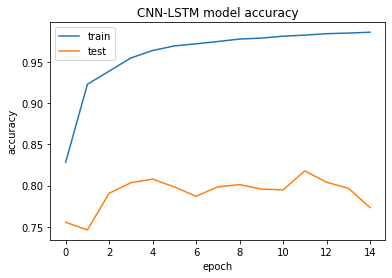

In [43]:
# summarize history for accuracy
plt.plot(history_cnn_lstm.history['accuracy'])
plt.plot(history_cnn_lstm.history['val_accuracy'])
plt.title('CNN-LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

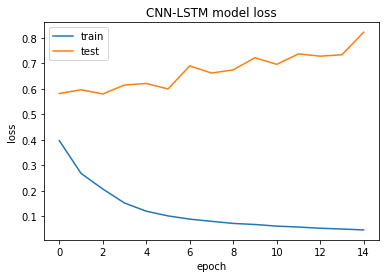

In [44]:
# summarize history for loss
plt.plot(history_cnn_lstm.history['loss'])
plt.plot(history_cnn_lstm.history['val_loss'])
plt.title('CNN-LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()